In [261]:
import pandas as pd
import numpy as np
import pickle
from tqdm.auto import tqdm
import re
import time
import csv

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


# 메인 text dataframe 불러오기
## - selected_dataset_text

In [2]:
# search_dataset_reconstructuring에서 만든 파일 사용
selected_dataset_text= pd.read_pickle('F:\cluster_test_2024\wos2413db_pkls\wos2024q1_text_info.pkl')

In [3]:
# 컬럼명을 기존 분석과 맞춰주기
selected_dataset_text.columns

Index(['uid', 'pubyear', 'title', 'keyword', 'abstract_cleaned'], dtype='object')

In [4]:
## 특히, 제목-저자키워드-초록 컬럼명은 동일해야 분석 과정에서 오류를 방지.
selected_dataset_text.columns = ['uid', 'pubyear', 'item', 'aukey', 'abstract']

In [7]:
# 검색을 위해 저자키워드 구분 기호 ';' 삭제
selected_dataset_text['aukey_modified'] = selected_dataset_text['aukey'].str.replace(';', ' ')

In [8]:
# na를 빈텍스트로 치환
selected_dataset_text = selected_dataset_text.fillna('')

In [9]:
# 분석 전 최종 데이터 확인
selected_dataset_text['pubyear'].max()

2023

# CASE별 함수 선언

In [10]:
# OR로만 이루어진 단순한 검색식의 경우 사용할 함수 선언
def search_and_organize(technology, search_texts, df_text_full_20_full,technology_search_results):
    technology_search_results = technology_search_results

    # aukey 컬럼에서 검색
    results_aukey = []
    for text in tqdm(search_texts, desc=f"search_in_aukey for {technology}"):
        result = df_text_full_20_full[df_text_full_20_full['aukey_modified'].str.contains(text, case=False, regex=True)]
        results_aukey.append(result)
    concatenated_results = pd.concat(results_aukey).drop_duplicates().reset_index(drop=True)

    # abstract 컬럼에서 검색
    results_abstract = []
    for text in tqdm(search_texts, desc=f"search_in_abstract for {technology}"):
        result_abs = df_text_full_20_full[df_text_full_20_full['abstract'].str.contains(text, case=False, regex=True)]
        results_abstract.append(result_abs)
    concatenated_results_abs = pd.concat(results_abstract).drop_duplicates().reset_index(drop=True)

    # 검색어를 포함하는 행의 수 계산
    shapes = [result.shape[0] for result in results_aukey]
    shapes_abs = [result_abs.shape[0] for result_abs in results_abstract]
    npubs_contain_searchterms = pd.DataFrame([shapes, shapes_abs]).T
    npubs_contain_searchterms.columns = ['aukey_npubs','abstract_npubs']
    npubs_contain_searchterms.index = search_texts
    npubs_contain_searchterms.loc['total_npubs'] = [concatenated_results.shape[0],concatenated_results_abs.shape[0]]

    # 결과를 딕셔너리에 저장
    technology_search_results[technology] = {
        'concatenated_results': concatenated_results,
        'concatenated_results_abs': concatenated_results_abs,
        'npubs_contain_searchterms': npubs_contain_searchterms
    }

    return technology_search_results

In [11]:
# AND가 2개의 OR검색식을 연결한 경우 사용할 함수 선언
def search_and_organize_1and(technology, search_texts_1st, search_texts_2nd, df_text_full_20_full,technology_search_results):

    # OR단순검색식 탐색 함수 1회 실행
    technology_search_results = search_and_organize(technology, search_texts_1st, df_text_full_20_full, technology_search_results)

    # 2차 검색식 정의
    search_texts_2nd = search_texts_2nd
    # 2차 검색 범위 정의
    concatenated_results1 = technology_search_results[technology]['concatenated_results']
    concatenated_results_abs1 = technology_search_results[technology]['concatenated_results_abs']
    npubs_contain_searchterms = technology_search_results[technology]['npubs_contain_searchterms']

    # aukey 컬럼에서 검색
    results_aukey = []
    for text in tqdm(search_texts_2nd, desc=f"search_in_aukey for {technology}"):
        result = concatenated_results1[concatenated_results1['aukey_modified'].str.contains(text, case=False, regex=True)]
        results_aukey.append(result)
    concatenated_results = pd.concat(results_aukey).drop_duplicates().reset_index(drop=True)

    # abstract 컬럼에서 검색
    results_abstract = []
    for text in tqdm(search_texts_2nd, desc=f"search_in_abstract for {technology}"):
        result_abs = concatenated_results_abs1[concatenated_results_abs1['abstract'].str.contains(text, case=False, regex=True)]
        results_abstract.append(result_abs)
    concatenated_results_abs = pd.concat(results_abstract).drop_duplicates().reset_index(drop=True)

    # 검색어를 포함하는 행의 수 계산
    shapes = [result.shape[0] for result in results_aukey]
    shapes_abs = [result_abs.shape[0] for result_abs in results_abstract]
    npubs_contain_searchterms1 = pd.DataFrame([shapes, shapes_abs]).T
    npubs_contain_searchterms1.columns = ['aukey_npubs','abstract_npubs']
    npubs_contain_searchterms1.index = search_texts_2nd
    npubs_contain_searchterms1.loc['total_npubs'] = [concatenated_results.shape[0],concatenated_results_abs.shape[0]]

    # 결과를 딕셔너리에 저장
    technology_search_results[technology] = {
        'concatenated_results': concatenated_results,
        'concatenated_results_abs': concatenated_results_abs,
        'npubs_contain_searchterms': pd.concat([npubs_contain_searchterms, npubs_contain_searchterms1])
    }

    return technology_search_results

In [220]:
def search_and_organize_combined(technology, search_text_groups, df_text_full_20_full, technology_search_results):
    combined_results_aukey = None
    combined_results_abstract = None
    combined_npubs_contain_searchterms_list = []

    # 각 search_text 그룹에 대해 search_and_organize 함수 실행
    for search_texts in search_text_groups:
        technology_search_results = search_and_organize(technology, search_texts, df_text_full_20_full, technology_search_results)
        
        # 현재 그룹의 결과 가져오기
        current_results = technology_search_results[technology]
        current_results_aukey = current_results['concatenated_results']
        current_results_abstract = current_results['concatenated_results_abs']
        current_npubs_contain_searchterms = current_results['npubs_contain_searchterms']

        # npubs_contain_searchterms 데이터프레임을 리스트에 추가  (다시 실행해 볼것!!!)
        combined_npubs_contain_searchterms_list.append(current_npubs_contain_searchterms)
        # npubs_contain_searchterms 데이터프레임을 리스트에 추가 (index를 컬럼으로 변환)
#        combined_npubs_contain_searchterms_list.append(current_npubs_contain_searchterms.reset_index())


        # 결과를 AND로 연결
        if combined_results_aukey is None:
            combined_results_aukey = current_results_aukey
        else:
            combined_results_aukey = pd.merge(combined_results_aukey, current_results_aukey, how='inner')
        
        if combined_results_abstract is None:
            combined_results_abstract = current_results_abstract
        else:
            combined_results_abstract = pd.merge(combined_results_abstract, current_results_abstract, how='inner')

    # npubs_contain_searchterms 데이터프레임들을 세로로 concat하여 combined_npubs_contain_searchterms 생성
    combined_npubs_contain_searchterms = pd.concat(combined_npubs_contain_searchterms_list).reset_index(drop=True)
    
    # total_npubs 행 추가
#    total_npubs = pd.DataFrame({'index': ['total_npubs'], 
#                                'aukey_npubs': [combined_npubs_contain_searchterms['aukey_npubs'].sum()/2], 
#                                'abstract_npubs': [combined_npubs_contain_searchterms['abstract_npubs'].sum()/2]})
#    combined_npubs_contain_searchterms = pd.concat([combined_npubs_contain_searchterms, total_npubs.set_index('index')])

    # total_npubs 행 추가
    total_npubs = pd.DataFrame({'index': ['total_npubs'], 
                                'aukey_npubs': [combined_results_aukey.shape[0]], 
                                'abstract_npubs': [combined_results_abstract.shape[0]]})
    combined_npubs_contain_searchterms = pd.concat([combined_npubs_contain_searchterms, total_npubs.set_index('index')])
    
    # 최종 결과 저장
    technology_search_results[technology] = {
        'concatenated_results': combined_results_aukey,
        'concatenated_results_abs': combined_results_abstract,
        'npubs_contain_searchterms': combined_npubs_contain_searchterms
#    technology_search_results[technology] = {
#        'combined_results_aukey': combined_results_aukey,
#        'combined_results_abstract': combined_results_abstract,
#        'combined_npubs_contain_searchterms': combined_npubs_contain_searchterms
        
    }

    return technology_search_results

In [231]:
# 최초 딕셔너리 선언
technology_search_results = {}

In [235]:
## case3 가장 복잡한 경우
# 기술명 선언
technology = '1-1. 금속 3D 프린팅(A-set)gpt'

# 1차 검색식 입력
search_texts_1st = [r'\bmetal\b']

# 2차 검색식 입력
search_texts_2nd = [
    '3D printing', 'Additive Manufacturing', 'Selective Laser Sintering', 
    'Selective Laser Melting', 'Powder Bed Fusion', 'Direct Energy Deposition'
]

# 검색식 재입력
search_text_groups = [search_texts_1st, search_texts_2nd]

In [236]:
technology_search_results = search_and_organize_combined(technology, search_text_groups, selected_dataset_text, technology_search_results)


search_in_aukey for 1-1. 금속 3D 프린팅(A-set)gpt:   0%|          | 0/1 [00:00<?, ?it/s]

search_in_abstract for 1-1. 금속 3D 프린팅(A-set)gpt:   0%|          | 0/1 [00:00<?, ?it/s]

search_in_aukey for 1-1. 금속 3D 프린팅(A-set)gpt:   0%|          | 0/6 [00:00<?, ?it/s]

search_in_abstract for 1-1. 금속 3D 프린팅(A-set)gpt:   0%|          | 0/6 [00:00<?, ?it/s]

In [241]:
technology_search_results[technology]['npubs_contain_searchterms']

,index,aukey_npubs,abstract_npubs
0,\bmetal\b,196908,847159
1,total_npubs,196908,847159
2,3D printing,18105,21294
3,Additive Manufacturing,22109,26175
4,Selective Laser Sintering,1095,1880
5,Selective Laser Melting,5284,6406
6,Powder Bed Fusion,4012,5611
7,Direct Energy Deposition,349,448
8,total_npubs,44163,52575
total_npubs,NaN,2168,7142


In [246]:
## case3 가장 복잡한 경우
# 기술명 선언 - 대안
technology = '1-1. 금속 3D 프린팅(A-set)gpt_smaller'
# 1차 검색식 입력
search_texts_1st = [r'\b3d\b(?:\s+\w+){0,4}\s+metal\b', r'\bmetal\b(?:\s+\w+){0,4}\s+3d\b']

# 2차 검색식 입력
search_texts_2nd = [
    '3D printing', 'Additive Manufacturing', 'Selective Laser Sintering', 
    'Selective Laser Melting', 'Powder Bed Fusion', 'Direct Energy Deposition'
]
# 검색식 재입력
search_text_groups = [search_texts_1st, search_texts_2nd]

In [250]:
technology_search_results = search_and_organize_combined(technology, search_text_groups, selected_dataset_text, technology_search_results)

search_in_aukey for 1-1. 금속 3D 프린팅(A-set)gpt_smaller:   0%|          | 0/2 [00:00<?, ?it/s]

search_in_abstract for 1-1. 금속 3D 프린팅(A-set)gpt_smaller:   0%|          | 0/2 [00:00<?, ?it/s]

search_in_aukey for 1-1. 금속 3D 프린팅(A-set)gpt_smaller:   0%|          | 0/6 [00:00<?, ?it/s]

search_in_abstract for 1-1. 금속 3D 프린팅(A-set)gpt_smaller:   0%|          | 0/6 [00:00<?, ?it/s]

In [15]:
# 예전 기록.
#technology_search_results['1-1. 금속 3D 프린팅(A-set)3']['npubs_contain_searchterms']

,aukey_npubs,abstract_npubs
"\b3d\b(?:\s+\w+){0,4}\s+metal\b",504,3158
"\bmetal\b(?:\s+\w+){0,4}\s+3d\b",389,857
total_npubs,875,3950
3D print.*,296,425
Additive Manufactur.*,110,198
\bAM\b,11,65
Rapid Prototyp.*,4,13
\bRP\b,0,6
\bSLS\b,0,8
Selective Laser Sintering,3,10


In [251]:
technology_search_results[technology]['npubs_contain_searchterms']

,index,aukey_npubs,abstract_npubs
0,"\b3d\b(?:\s+\w+){0,4}\s+metal\b",504,3158
1,"\bmetal\b(?:\s+\w+){0,4}\s+3d\b",389,857
2,total_npubs,875,3950
3,3D printing,18105,21294
4,Additive Manufacturing,22109,26175
5,Selective Laser Sintering,1095,1880
6,Selective Laser Melting,5284,6406
7,Powder Bed Fusion,4012,5611
8,Direct Energy Deposition,349,448
9,total_npubs,44163,52575


In [252]:
print(f'technology = {technology}')

technology = 1-1. 금속 3D 프린팅(A-set)gpt_smaller


In [253]:
technology_search_results.keys()

dict_keys(['1-1. 금속 3D 프린팅(A-set)gpt', '1-1. 금속 3D 프린팅(A-set)gpt_smaller'])

In [254]:
# 3차 검색식 입력
search_texts_3rd = [
    'Metal 3D Print.*', 'Direct Metal Printing', 'Direct Metal Laser Sintering', 'Direct Metal Laser Melting'
]

In [255]:
# OR단순검색식 탐색 함수 실행
technology = '1-2. 금속 3D 프린팅(B-set)gpt'

In [256]:
technology_search_results = search_and_organize(technology, search_texts_3rd, selected_dataset_text , technology_search_results)

search_in_aukey for 1-2. 금속 3D 프린팅(B-set)gpt:   0%|          | 0/4 [00:00<?, ?it/s]

search_in_abstract for 1-2. 금속 3D 프린팅(B-set)gpt:   0%|          | 0/4 [00:00<?, ?it/s]

In [257]:
technology_search_results[technology]['npubs_contain_searchterms']

,aukey_npubs,abstract_npubs
Metal 3D Print.*,98,194
Direct Metal Printing,12,19
Direct Metal Laser Sintering,271,565
Direct Metal Laser Melting,7,33
total_npubs,385,801


In [19]:
# 예전 기록.
#technology_search_results['1-2. 금속 3D 프린팅(B-set)']['npubs_contain_searchterms']

,aukey_npubs,abstract_npubs
\bDMP\b,310,4257
Direct Metal Printing,12,19
\bDMLS\b,185,620
Direct Metal Laser Sintering,271,565
\bDMLM\b,3,30
Direct Metal Laser Melting,7,33
total_npubs,706,5110


In [258]:
type(technology_search_results)

dict

In [259]:
#중간 점검
technology_search_results.keys()

dict_keys(['1-1. 금속 3D 프린팅(A-set)gpt', '1-1. 금속 3D 프린팅(A-set)gpt_smaller', '1-2. 금속 3D 프린팅(B-set)gpt'])

In [260]:
# 7번 다시.
# 기술명 선언
technology = '7. 초대용량 데이터 대응 광통신 기술_gpt'
# 7-gpt - AND 2개.
search_text_groups = [
    ["high capacity data", "large capacity data", "optical communication", "optical transmission"
    ],
    ["Multicore fiber", "Multi core fiber"
      , r'\bMCF\b', "multimode fiber", "multi mode fiber"
      , r'\bFMF\b', "Few Mode Fiber", "FewMode Fiber", "Spatial Division Multiplexing"
      , r'\bSDM\b', "Space Division Multiplexing", "Frequency Division Multiplexing"
      , r'\bFDM\b', "Time Division Multiplexing", r'\bTDM\b', "Code Division Multiplexing"
      , r'\bCDM\b', "Wavelength Division Multiplexing", r'\bWDM\b'
    ]
]
technology_search_results = search_and_organize_combined(technology, search_text_groups, selected_dataset_text, technology_search_results)


search_in_aukey for 7. 초대용량 데이터 대응 광통신 기술_gpt:   0%|          | 0/4 [00:00<?, ?it/s]

search_in_abstract for 7. 초대용량 데이터 대응 광통신 기술_gpt:   0%|          | 0/4 [00:00<?, ?it/s]

search_in_aukey for 7. 초대용량 데이터 대응 광통신 기술_gpt:   0%|          | 0/19 [00:00<?, ?it/s]

search_in_abstract for 7. 초대용량 데이터 대응 광통신 기술_gpt:   0%|          | 0/19 [00:00<?, ?it/s]

In [218]:
technology

'7. 초대용량 데이터 대응 광통신 기술_gpt'

In [263]:
print(f'technology = {technology}')
print(technology_search_results[technology]['npubs_contain_searchterms'])

technology = 7. 초대용량 데이터 대응 광통신 기술_gpt
                                        index  aukey_npubs  abstract_npubs
0                          high capacity data            3              49
1                         large capacity data            0              13
2                       optical communication         4311            9800
3                        optical transmission          892            6911
4                                 total_npubs         5185           16614
5                             Multicore fiber          312             629
6                            Multi core fiber           10               5
7                                     \bMCF\b         3874           40908
8                             multimode fiber          518            2285
9                            multi mode fiber            5              28
10                                    \bFMF\b          340            2656
11                             Few Mode Fiber           89   

In [164]:
# # 기술명 선언
# technology = '7. 초대용량 데이터 대응 광통신 기술_claude'
# # 7-claude - AND 4개.
# search_text_groups = [
#     [r'\bMCF\b', "Multicore fiber", "Multi core fiber", "multimode fiber"
#     , "multi mode fiber", r'\bFMF\b', "Few Mode Fiber", "FewMode Fiber"] 
#     ,  ["Spacial Multiplexing", r'\bSM\b', "Spatial Division Multiplexing"
#         , r'b\SDM\b', "Space Division Multiplexing"] 
#     ,  ["PAM-4", "pulse-amplitude modulation", "pulse amplitude modulation"] 
#     ,  [r'\bWDM\b', "Wavelength Division Multiplexing"]
# ]
# technology_search_results = search_and_organize_combined(technology, search_text_groups, selected_dataset_text, technology_search_results)


search_in_aukey for 7. 초대용량 데이터 대응 광통신 기술_claude:   0%|          | 0/8 [00:00<?, ?it/s]

search_in_abstract for 7. 초대용량 데이터 대응 광통신 기술_claude:   0%|          | 0/8 [00:00<?, ?it/s]

search_in_aukey for 7. 초대용량 데이터 대응 광통신 기술_claude:   0%|          | 0/5 [00:00<?, ?it/s]

search_in_abstract for 7. 초대용량 데이터 대응 광통신 기술_claude:   0%|          | 0/5 [00:00<?, ?it/s]

search_in_aukey for 7. 초대용량 데이터 대응 광통신 기술_claude:   0%|          | 0/3 [00:00<?, ?it/s]

search_in_abstract for 7. 초대용량 데이터 대응 광통신 기술_claude:   0%|          | 0/3 [00:00<?, ?it/s]

search_in_aukey for 7. 초대용량 데이터 대응 광통신 기술_claude:   0%|          | 0/2 [00:00<?, ?it/s]

search_in_abstract for 7. 초대용량 데이터 대응 광통신 기술_claude:   0%|          | 0/2 [00:00<?, ?it/s]

In [166]:
# print(f'technology = {technology}')
# print(technology_search_results[technology]['combined_npubs_contain_searchterms'])

technology = 7. 초대용량 데이터 대응 광통신 기술_claude
                                        index  aukey_npubs  abstract_npubs
0                                     \bMCF\b         3874           40908
1                             Multicore fiber          312             629
2                            Multi core fiber           10               5
3                             multimode fiber          518            2285
4                            multi mode fiber            5              28
5                                     \bFMF\b          340            2656
6                              Few Mode Fiber           89             121
7                               FewMode Fiber            1               5
8                                 total_npubs         5076           46247
9                        Spacial Multiplexing            0               0
10                                     \bSM\b         6552           52438
11              Spatial Division Multiplexing           86

In [ ]:
# technology = 7. 초대용량 데이터 대응 광통신 기술_claude 검색식은 공집합.

In [264]:
#중간 점검2
technology_search_results.keys()

dict_keys(['1-1. 금속 3D 프린팅(A-set)gpt', '1-1. 금속 3D 프린팅(A-set)gpt_smaller', '1-2. 금속 3D 프린팅(B-set)gpt', '7. 초대용량 데이터 대응 광통신 기술_gpt'])

In [265]:
#새로 뽑은 1,7만
technology_search_results.keys()

dict_keys(['1-1. 금속 3D 프린팅(A-set)gpt', '1-1. 금속 3D 프린팅(A-set)gpt_smaller', '1-2. 금속 3D 프린팅(B-set)gpt', '7. 초대용량 데이터 대응 광통신 기술_gpt'])

In [169]:
## 최종 파일 피클 저장 후 세부 내용 체크
#df_technology_search_results = pd.DataFrame(technology_search_results)
#df_technology_search_results.to_pickle('technology_search_results_2018top10_1,7_240603.pkl')

In [267]:
df_technology_search_results

,1-1. 금속 3D 프린팅(A-set)gpt,1-2. 금속 3D 프린팅(B-set)gpt,1-1. 금속 3D 프린팅(A-set)gpt_smaller,7. 초대용량 데이터 대응 광통신 기술_gpt
concatenated_results,uid pubyear \ 0 WO...,uid pubyear \ 0 WOS:...,uid pubyear \ 0 WOS:...,uid pubyear \ 0 WOS:...
concatenated_results_abs,uid pubyear \ 0 WO...,uid pubyear \ 0 WOS:...,uid pubyear \ 0 WOS:...,uid pubyear \ 0 WOS:...
npubs_contain_searchterms,aukey_npubs abstra...,aukey_npubs abs...,aukey_npubs ...,index ...


In [268]:
df_technology_search_results.index

Index(['concatenated_results', 'concatenated_results_abs',
       'npubs_contain_searchterms'],
      dtype='object')

In [269]:
df_technology_search_results.columns

Index(['1-1. 금속 3D 프린팅(A-set)gpt', '1-2. 금속 3D 프린팅(B-set)gpt',
       '1-1. 금속 3D 프린팅(A-set)gpt_smaller', '7. 초대용량 데이터 대응 광통신 기술_gpt'],
      dtype='object')

In [ ]:
# 뽑힌 데이터 저장
# 데이터 저장을 위한 데스트 작업 먼저

In [207]:
techs = sorted(list(df_technology_search_results.columns))

In [208]:
techs

['1-1. 금속 3D 프린팅(A-set)gpt',
 '1-1. 금속 3D 프린팅(A-set)gpt_smaller',
 '1-2. 금속 3D 프린팅(B-set)gpt',
 '7. 초대용량 데이터 대응 광통신 기술_gpt']

In [276]:
technology_search_results['1-1. 금속 3D 프린팅(A-set)gpt']['concatenated_results']

,uid,pubyear,item,aukey,abstract,aukey_modified
0,WOS:000234519300006,2006,An approach to minimize build errors in direct...,compensation method (SC);dexel;direct metal la...,This paper discusses the effect of geometric s...,compensation method (SC) dexel direct metal la...
1,WOS:000237339000021,2006,Microstructure and property of sub-micro WC-10...,selective laser sintering;metal matrix composi...,The WC-10%Co particulate reinforced Cu matrix ...,selective laser sintering metal matrix composi...
2,WOS:000240623800068,2006,Microstructure of the WC-10%Co particulate rei...,selective laser sintering;metal matrix composi...,The WC-10%Co particulate reinforced Cu matrix ...,selective laser sintering metal matrix composi...
3,WOS:000248201800031,2007,Porous 316 stainless steel of lotus root-shape...,316 stainless steel;lotus-root-shape porous me...,The basic principle and processes of a new fab...,316 stainless steel lotus-root-shape porous me...
4,WOS:000250155600006,2007,An experimental determination of optimum proce...,additive manufacturing;ultrasonic consolidatio...,"Ultrasonic consolidation, an emerging additive...",additive manufacturing ultrasonic consolidatio...
...,...,...,...,...,...,...
2163,WOS:000922172000007,2023,Evaluation of fabrication parameters for foam ...,Additive manufacturing;Directed energy deposit...,"Directed energy deposition (DED), a metal addi...",Additive manufacturing Directed energy deposit...
2164,WOS:000995867700001,2023,A drug-loaded composite coating to improve ost...,Additive manufacturing;Biodegradable metal;Zn ...,Zinc (Zn) alloy porous scaffolds produced by a...,Additive manufacturing Biodegradable metal Zn ...
2165,WOS:001100909900001,2023,Evaluation of computationally optimized design...,Design for additive manufacturing;Cost-benefit...,The additive manufacturing industry requires e...,Design for additive manufacturing Cost-benefit...
2166,WOS:001022815400001,2023,In-situ porosity prediction in metal powder be...,Prior-guided neural network;Machine learning;S...,Numerous efforts in the additive manufacturing...,Prior-guided neural network Machine learning S...


In [195]:
# tech의 특수문자 처리 함수
import re

def sanitize_filename(name):
    return re.sub(r'[\/:*?"<>|]', '_', name)

In [277]:
import os

for tech in techs:
    safe_tech = sanitize_filename(tech)  # 파일 이름을 안전하게 변환
    print(safe_tech)
    base_path = 'F:/cluster_test_2024/search_results_2024-06-04'
    os.makedirs(base_path, exist_ok=True)  # 폴더가 없으면 생성

    technology_search_results[tech]['concatenated_results'].to_csv(
        os.path.join(base_path, f'{safe_tech}_search_results_from_aukey.csv')
    )
    technology_search_results[tech]['concatenated_results_abs'].to_csv(
        os.path.join(base_path, f'{safe_tech}_search_results_from_abstract.csv')
    )
    technology_search_results[tech]['npubs_contain_searchterms'].to_csv(
        os.path.join(base_path, f'{safe_tech}_npubs_contain_searchterms.csv')
    )


1-1. 금속 3D 프린팅(A-set)gpt
1-1. 금속 3D 프린팅(A-set)gpt_smaller
1-2. 금속 3D 프린팅(B-set)gpt
7. 초대용량 데이터 대응 광통신 기술_gpt


In [281]:
technology_search_results[tech]['npubs_contain_searchterms']

,index,aukey_npubs,abstract_npubs
0,high capacity data,3,49
1,large capacity data,0,13
2,optical communication,4311,9800
3,optical transmission,892,6911
4,total_npubs,5185,16614
5,Multicore fiber,312,629
6,Multi core fiber,10,5
7,\bMCF\b,3874,40908
8,multimode fiber,518,2285
9,multi mode fiber,5,28


In [279]:
termlist =  list(technology_search_results[tech]['npubs_contain_searchterms'].index)

In [54]:
df = technology_search_results[tech]['concatenated_results']

In [65]:
# 각 용어(term)이 df(저자키워드 검색결과), df_abs(초록 검색결과)에서 어느 행의 검색에 기여했는지를 찾고
# , 이를 새 컬럼(True/False)으로 추가하고, csv로 저장
for tech in tqdm(techs, desc=f'processing tech {tech}'):
    safe_tech = sanitize_filename(tech)  # 파일 이름을 안전하게 변환
    print(safe_tech)
    base_path = 'F:/cluster_test_2024/search_results_2024-06-04'
    os.makedirs(base_path, exist_ok=True)  # 폴더가 없으면 생성

    termlist =  list(technology_search_results[tech]['npubs_contain_searchterms'].index)
    df = technology_search_results[tech]['concatenated_results']
    df_abs = technology_search_results[tech]['concatenated_results_abs']
    for term in tqdm(termlist, desc = 'search terms in aukey'):
        df[term] = df['aukey_modified'].str.contains(f".*{term}.*", case=False, regex=True)
    for term in tqdm(termlist, desc = 'search terms in abstract'):
        df_abs[term] = df_abs['abstract'].str.contains(f".*{term}.*", case=False, regex=True)
    df.to_csv(
        os.path.join(base_path, f'{safe_tech}_search_results_from_aukey_updated.csv')
    )
    df_abs.to_csv(
        os.path.join(base_path, f'{safe_tech}_search_results_from_abstract_updated.csv')
    )
    print(tech)

processing tech 9. 나노유체 이용 에너지 효율화:   0%|          | 0/11 [00:00<?, ?it/s]

1-1. 금속 3D 프린팅(A-set)3


search terms in aukey:   0%|          | 0/23 [00:00<?, ?it/s]

search terms in abstract:   0%|          | 0/23 [00:00<?, ?it/s]

1-1. 금속 3D 프린팅(A-set)3
1-2. 금속 3D 프린팅(B-set)


search terms in aukey:   0%|          | 0/7 [00:00<?, ?it/s]

search terms in abstract:   0%|          | 0/7 [00:00<?, ?it/s]

1-2. 금속 3D 프린팅(B-set)
10. 상변화 소재 활용 열에너지 저장


search terms in aukey:   0%|          | 0/3 [00:00<?, ?it/s]

search terms in abstract:   0%|          | 0/3 [00:00<?, ?it/s]

10. 상변화 소재 활용 열에너지 저장
2. 신축성 전자소자


search terms in aukey:   0%|          | 0/12 [00:00<?, ?it/s]

search terms in abstract:   0%|          | 0/12 [00:00<?, ?it/s]

2. 신축성 전자소자
3. 휴먼 마이크로바이옴


search terms in aukey:   0%|          | 0/10 [00:00<?, ?it/s]

search terms in abstract:   0%|          | 0/10 [00:00<?, ?it/s]

3. 휴먼 마이크로바이옴
4. 암 진단_예측 바이오마커


search terms in aukey:   0%|          | 0/6 [00:00<?, ?it/s]

search terms in abstract:   0%|          | 0/6 [00:00<?, ?it/s]

4. 암 진단/예측 바이오마커
5. 유전자 편집


search terms in aukey:   0%|          | 0/11 [00:00<?, ?it/s]

search terms in abstract:   0%|          | 0/11 [00:00<?, ?it/s]

5. 유전자 편집
6.무선 전력 전송


search terms in aukey:   0%|          | 0/5 [00:00<?, ?it/s]

search terms in abstract:   0%|          | 0/5 [00:00<?, ?it/s]

6.무선 전력 전송
7. 초대용량 데이터 대응 광통신 기술


search terms in aukey:   0%|          | 0/15 [00:00<?, ?it/s]

search terms in abstract:   0%|          | 0/15 [00:00<?, ?it/s]

7. 초대용량 데이터 대응 광통신 기술
8. 면역세포치료


search terms in aukey:   0%|          | 0/3 [00:00<?, ?it/s]

search terms in abstract:   0%|          | 0/3 [00:00<?, ?it/s]

8. 면역세포치료
9. 나노유체 이용 에너지 효율화


search terms in aukey:   0%|          | 0/6 [00:00<?, ?it/s]

search terms in abstract:   0%|          | 0/6 [00:00<?, ?it/s]

9. 나노유체 이용 에너지 효율화


In [283]:
# df_abs(초록 검색결과) 중, df(저자키워드 검색결과)에 존재하는 행을 제외한 나머지행만 따로 추출하여 csv 저장

for tech in tqdm(techs):
    safe_tech = sanitize_filename(tech)  # 파일 이름을 안전하게 변환
    print(safe_tech)
    base_path = 'F:/cluster_test_2024/search_results_2024-06-04'
    os.makedirs(base_path, exist_ok=True)  # 폴더가 없으면 생성
    
    df = technology_search_results[tech]['concatenated_results']
    df_abs = technology_search_results[tech]['concatenated_results_abs']
    df_abs_div = df_abs.loc[~(df_abs['uid'].isin(df['uid']))]
    df_abs_div.to_csv(
        os.path.join(base_path, f'{safe_tech}_only-abs_not-aukey.csv')
    )

  0%|          | 0/4 [00:00<?, ?it/s]

1-1. 금속 3D 프린팅(A-set)gpt
1-1. 금속 3D 프린팅(A-set)gpt_smaller
1-2. 금속 3D 프린팅(B-set)gpt
7. 초대용량 데이터 대응 광통신 기술_gpt


In [284]:
df_technology_search_results

,1-1. 금속 3D 프린팅(A-set)gpt,1-2. 금속 3D 프린팅(B-set)gpt,1-1. 금속 3D 프린팅(A-set)gpt_smaller,7. 초대용량 데이터 대응 광통신 기술_gpt
concatenated_results,uid pubyear \ 0 WO...,uid pubyear \ 0 WOS:...,uid pubyear \ 0 WOS:...,uid pubyear \ 0 WOS:...
concatenated_results_abs,uid pubyear \ 0 WO...,uid pubyear \ 0 WOS:...,uid pubyear \ 0 WOS:...,uid pubyear \ 0 WOS:...
npubs_contain_searchterms,aukey_npubs abstra...,aukey_npubs abs...,aukey_npubs ...,index ...


In [ ]:
# 다른 관점의 데이터 묶음 저장 키워드 OR 초록 에서 검색 결과 (uid와 텍스트, bibs 정보?)

In [285]:
# 두 데이터프레임의 합집합을 만들고 중복 제거

for tech in tqdm(techs):
    safe_tech = sanitize_filename(tech)  # 파일 이름을 안전하게 변환
    print(safe_tech)
    base_path = 'F:/cluster_test_2024/search_results_2024-06-04'
    os.makedirs(base_path, exist_ok=True)  # 폴더가 없으면 생성
    
    df = technology_search_results[tech]['concatenated_results']
    df_abs = technology_search_results[tech]['concatenated_results_abs']
    df_combined = pd.concat([df[['uid', 'pubyear', 'item', 'aukey', 'abstract']], 
                             df_abs[['uid', 'pubyear', 'item', 'aukey', 'abstract']]]).drop_duplicates().reset_index(drop=True)
    
    
    df_combined.to_csv(
        os.path.join(base_path, f'{safe_tech}_aukey_or_abs_search_results_textinfo.csv')
    )

  0%|          | 0/4 [00:00<?, ?it/s]

1-1. 금속 3D 프린팅(A-set)gpt
1-1. 금속 3D 프린팅(A-set)gpt_smaller
1-2. 금속 3D 프린팅(B-set)gpt
7. 초대용량 데이터 대응 광통신 기술_gpt


In [289]:
len(techs)

4

  0%|          | 0/4 [00:00<?, ?it/s]

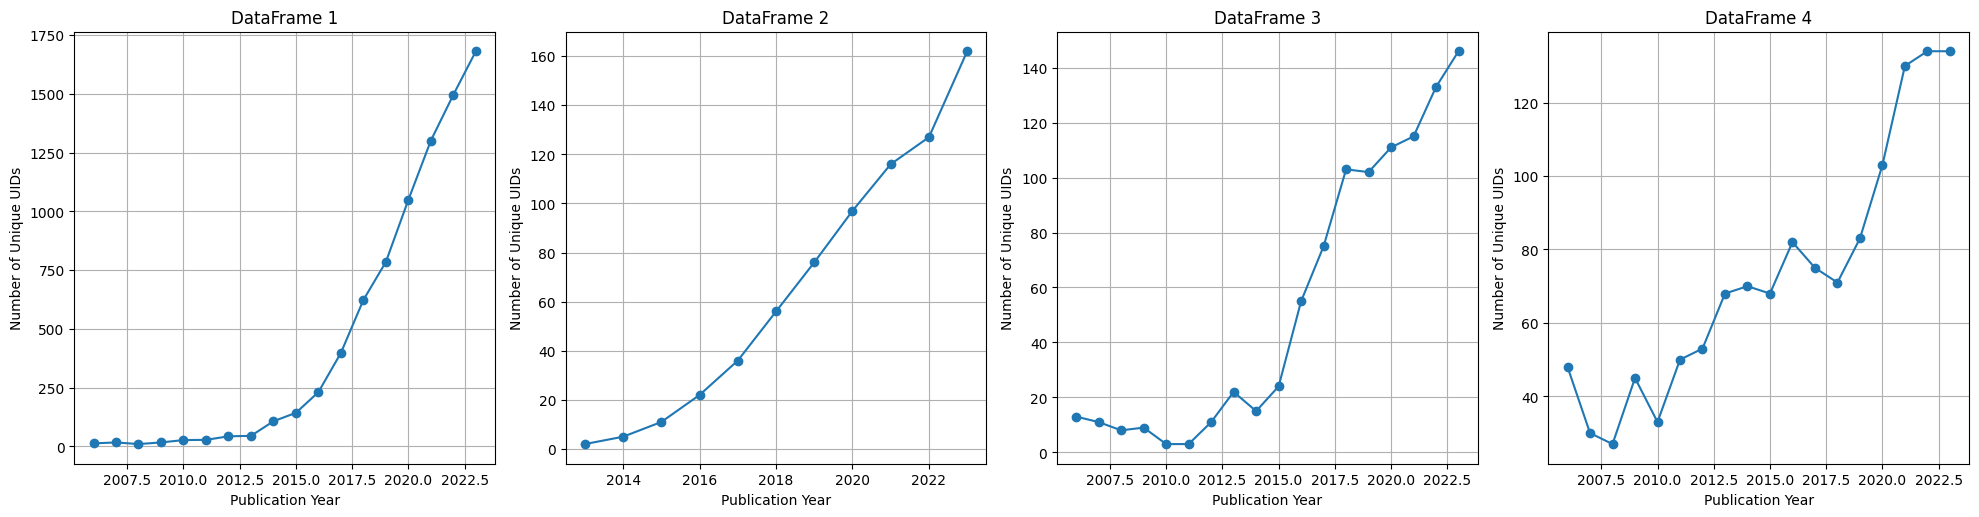

In [287]:
import matplotlib.pyplot as plt

# 딕셔너리에 df_combined 저장
df_combined_dict = {}

for i in tqdm(range(0, len(techs))):
    tech = techs[i]
    df = technology_search_results[tech]['concatenated_results']
    df_abs = technology_search_results[tech]['concatenated_results_abs']
    df_combined = pd.concat([df[['uid', 'pubyear', 'item', 'aukey', 'abstract']], 
                             df_abs[['uid', 'pubyear', 'item', 'aukey', 'abstract']]]).drop_duplicates().reset_index(drop=True)
    df_combined_dict[tech] = df_combined

# df_combined_dict의 값을 리스트로 변환
df_combined_list = list(df_combined_dict.values())

# 서브플롯 생성 (3행 4열, 마지막 하나는 빈 서브플롯이 됨)
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
axes = axes.flatten()

# 각 데이터프레임에 대해 그래프 생성
for i, df_combined in enumerate(df_combined_list):
    # pubyear에 따른 uid 수 집계
    uid_counts = df_combined.groupby('pubyear')['uid'].nunique().reset_index()

    # 서브플롯에 그래프 그리기
    axes[i].plot(uid_counts['pubyear'], uid_counts['uid'], marker='o', linestyle='-')
    axes[i].set_title(f'DataFrame {i+1}')
    axes[i].set_xlabel('Publication Year')
    axes[i].set_ylabel('Number of Unique UIDs')
    axes[i].grid(True)

# 레이아웃 조정
plt.tight_layout()

# 마지막 서브플롯을 빈 플롯으로 유지 (없앨 수도 있음)
if len(df_combined_list) < len(axes):
    for j in range(len(df_combined_list), len(axes)):
        fig.delaxes(axes[j])

# 그래프 표시
plt.show()


In [288]:
# df_abs(초록 검색결과) 중, df(저자키워드 검색결과)에 존재하는 행을 제외한 나머지행만 따로 추출하여 csv 저장
for i in tqdm(range(0,len(techs))):
    print(techs[i])
    tech = techs[i]
    safe_tech = sanitize_filename(tech)  # 파일 이름을 안전하게 변환
    print(safe_tech)
    base_path = 'F:/cluster_test_2024/search_results_2024-06-04'
    os.makedirs(base_path, exist_ok=True)  # 폴더가 없으면 생성

    df = technology_search_results[techs[i]]['concatenated_results']
    df_abs = technology_search_results[techs[i]]['concatenated_results_abs']
    df_abs_div = df_abs.loc[~(df_abs['uid'].isin(df['uid']))]
    df_abs_div.to_csv(
        os.path.join(base_path, f'{safe_tech}_only-abs_not-aukey.csv')
    )

  0%|          | 0/4 [00:00<?, ?it/s]

1-1. 금속 3D 프린팅(A-set)gpt
1-1. 금속 3D 프린팅(A-set)gpt
1-1. 금속 3D 프린팅(A-set)gpt_smaller
1-1. 금속 3D 프린팅(A-set)gpt_smaller
1-2. 금속 3D 프린팅(B-set)gpt
1-2. 금속 3D 프린팅(B-set)gpt
7. 초대용량 데이터 대응 광통신 기술_gpt
7. 초대용량 데이터 대응 광통신 기술_gpt


## 두 결과 합집합 만들기